# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

1. Данные о клиентах банка:

    * `age` (возраст);
    * `job` (сфера занятости);
    * `marital` (семейное положение);
    * `education` (уровень образования);
    * `default` (имеется ли просроченный кредит);
    * `housing` (имеется ли кредит на жильё);
    * `loan` (имеется ли кредит на личные нужды);
    * `balance` (баланс).

2.  Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

    * ` contact` (тип контакта с клиентом);
    * `month` (месяц, в котором был последний контакт);
    * `day` (день, в который был последний контакт);
    * `duration` (продолжительность контакта в секундах).

3. Прочие признаки:

    * `campaign` (количество контактов с этим клиентом в течение текущей кампании);
    * `pdays` (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
    * `previous` (количество контактов до текущей кампании)
    * `poutcome` (результат прошлой маркетинговой кампании).
    * И, разумеется, наша целевая переменная `deposit`, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.info()
print(f'Sum of missing data in `balance` feature: {df.balance.isnull().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB
Sum of missing data in `balance` feature: 25


Пропуски есть только в признаке `balance`, который отвечает за баланс клиента на счету.

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [5]:
data = df.copy()

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance_new'] = df['balance'].str.replace('$','').str.replace(',', '.').str.replace(' ','')
df['balance_new'] = df['balance_new'].astype(float)
df.drop('balance', axis=1, inplace=True)
print(round(df['balance_new'].mean(),3))

1529.129


### Задание 4

In [7]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance_new'].fillna(df['balance_new'].median(), inplace=True)
print(round(df['balance_new'].mean(),3))

1526.936


### Задание 5

In [8]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job_new'] = df['job'].replace('unknown', np.nan)
df['job_new'].fillna('management', inplace=True)

df['education_new'] = df['education'].replace('unknown', np.nan)
df['education_new'].fillna('secondary', inplace=True)

print(df['job_new'].value_counts().head(1))
print(df['education_new'].value_counts().head(1))

average_balance = df.loc[(df['job_new']=='management') & (df['education_new']=='secondary'),'balance_new'].mean()
print(round(average_balance,3))


management    2636
Name: job_new, dtype: int64
secondary    5973
Name: education_new, dtype: int64
1598.883


In [9]:
df.describe()

,age,day,duration,campaign,pdays,previous,balance_new
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,15.658036,371.993818,2.508421,51.330407,0.832557,1526.936033
std,11.913369,8.420740,347.128386,2.722077,108.758282,2.292007,3224.829691
min,18.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,-6847.000000
25%,32.000000,8.000000,138.000000,1.000000,-1.000000,0.000000,123.000000
50%,39.000000,15.000000,255.000000,2.000000,-1.000000,0.000000,550.000000
75%,49.000000,22.000000,496.000000,3.000000,20.750000,1.000000,1699.000000
max,95.000000,31.000000,3881.000000,63.000000,854.000000,58.000000,81204.000000


### Задание 6

In [10]:
# удалите все выбросы для признака balance
# ваш код
q3 = np.percentile(a=df['balance_new'], q=75)
q1 = np.percentile(a=df['balance_new'], q=25)
iqr = q3 - q1

lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

filtered_df = df[(df['balance_new'] >= lower_bound) & (df['balance_new'] <= upper_bound)] 

print(filtered_df['balance_new'].shape[0])
print(lower_bound)
print(upper_bound) 

10105
-2241.0
4063.0


In [11]:
df = filtered_df

## Часть 2:  Разведывательный анализ

### Задание 1

In [12]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
df['deposit'].value_counts()


no     5424
yes    4681
Name: deposit, dtype: int64

### Задания 2 и 3

In [13]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df.describe()

,age,day,duration,campaign,pdays,previous,balance_new
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,15.590302,368.742603,2.517170,51.319644,0.816230,807.653538
std,11.734931,8.441510,346.651524,2.707159,109.644179,2.243795,994.151966
min,18.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,-2049.000000
25%,32.000000,8.000000,137.000000,1.000000,-1.000000,0.000000,95.000000
50%,38.000000,15.000000,252.000000,2.000000,-1.000000,0.000000,445.000000
75%,48.000000,22.000000,490.000000,3.000000,2.000000,1.000000,1227.000000
max,95.000000,31.000000,3881.000000,43.000000,854.000000,58.000000,4063.000000


In [14]:
df['job_new'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'self-employed', 'student'], dtype=object)

### Задания 4 и 5

In [15]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
df['month'].value_counts()

may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb     709
oct     335
jan     319
sep     278
mar     237
dec      93
Name: month, dtype: int64

In [ ]:
for i in np.unique(df.month):
    print(i, df[(df.month==i)&(df.deposit=='no')].shape[0]/df[(df.month==i)].shape[0])

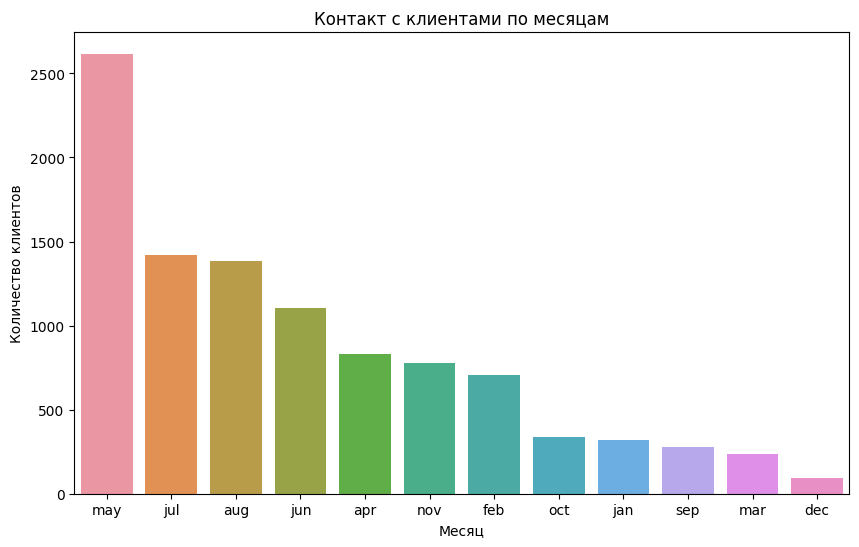

In [16]:
months = dict(df['month'].value_counts())
months_list = list(months.keys())
values = list(months.values())

plt.figure(figsize=(10,6))
sns.barplot(x=months_list, y=values)
plt.title('Контакт с клиентами по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество клиентов')
plt.show()

Посмотрим также на количество открывших депозит людей в зависимости от месяца:

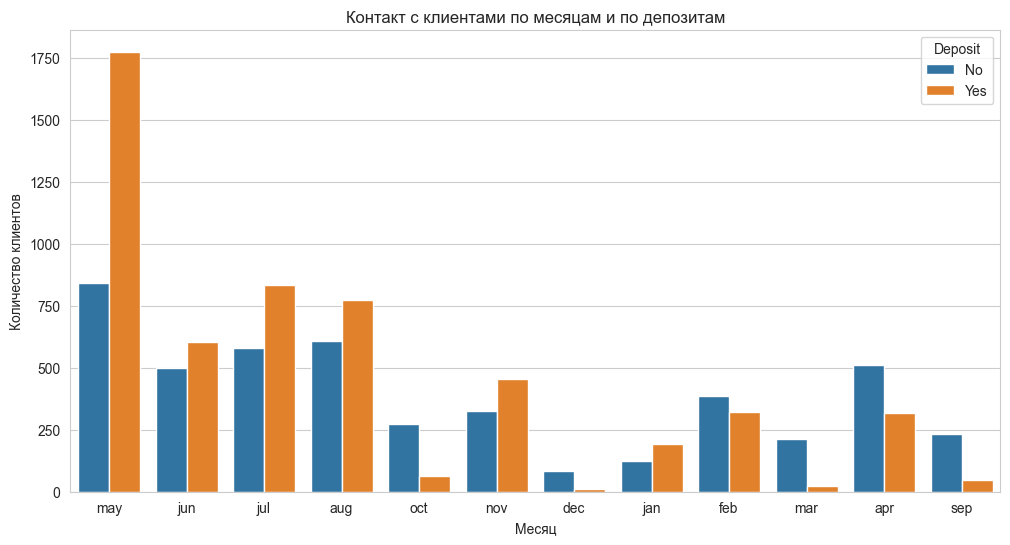

In [17]:
# Проверим уникальные значения в столбце 'month'
unique_months = df['month'].unique()

# можно использовать countplot для автоматической группировки по месяцам и
# визуализации значений
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='month', hue='deposit')
plt.title('Контакт с клиентами по месяцам и по депозитам')
plt.xlabel('Месяц')
plt.ylabel('Количество клиентов')
plt.legend(title='Deposit', loc='upper right', labels=['No', 'Yes'])
plt.show()

Посмотрим на взаимосвязь открытия депозита и имеющимся кредитом на дом:

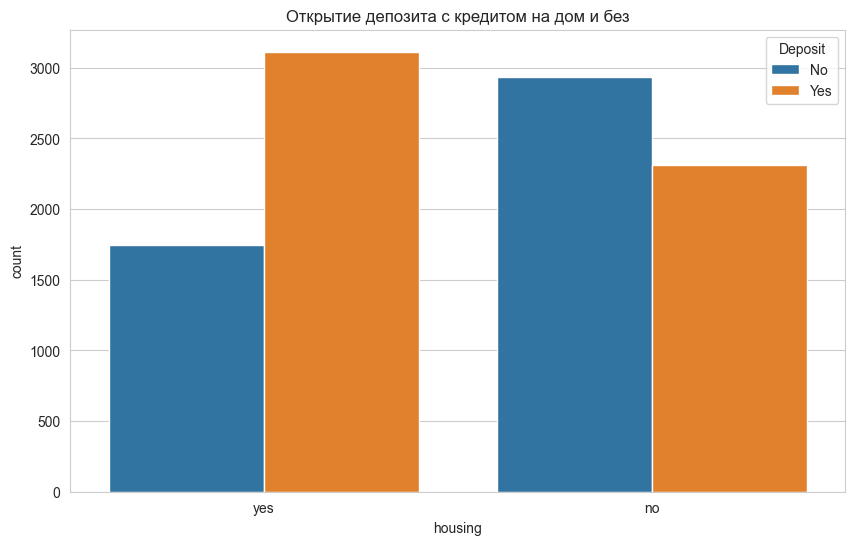

In [18]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='housing', hue='deposit')
plt.title('Открытие депозита с кредитом на дом и без')
plt.xlabel('housing')
plt.ylabel('count')
plt.legend(title='Deposit',loc='upper right', labels=['No', 'Yes'])
plt.show()

In [19]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit,job_new,education_new
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,12,3,4,2,2,2,3,12,4,2,11,3
top,management,married,secondary,no,no,no,cellular,may,unknown,no,management,secondary
freq,2254,5715,5078,9939,5243,8712,7283,2617,7570,5424,2315,5517


In [20]:
df.drop(['job', 'education'], axis=1, inplace=True)

### Задание 6

In [21]:
df.groupby('poutcome')['deposit'].agg('value_counts')

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

### Задание 7

In [22]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
result = df.groupby('month')['deposit'].value_counts(normalize=True)
filtered = result.loc[:, 'no']
print(filtered.nlargest(1))

month
may    0.67864
Name: deposit, dtype: float64


### Задание 8

In [23]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_cat'] =  pd.cut(df['age'],
                        bins=[0, 30, 40, 50, 60, 100],
                        labels=['<30', '30-40', '40-50','50-60', '60+'])


Text(0, 0.5, 'count')

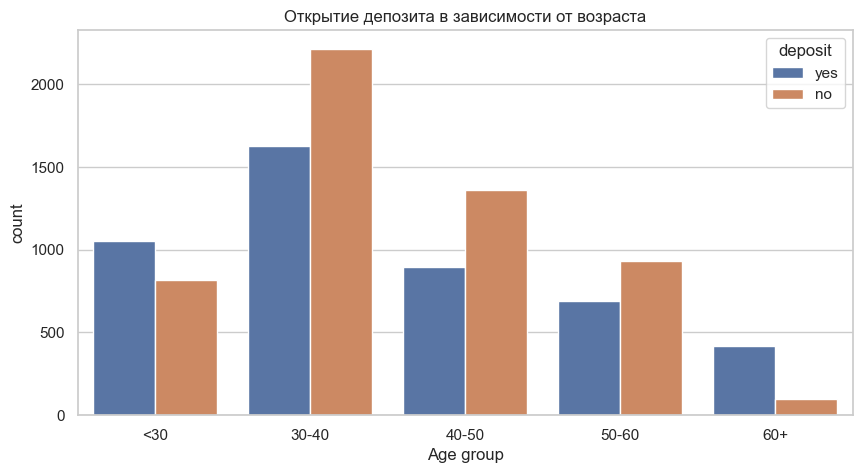

In [24]:
plt.figure(figsize=(10,5))
sns.set(style='whitegrid')
sns.countplot(data=df, x='age_cat', hue='deposit')
plt.title('Открытие депозита в зависимости от возраста')
plt.xlabel('Age group')
plt.ylabel('count')

### Задания 9 и 10

Text(0, 0.5, 'Count')

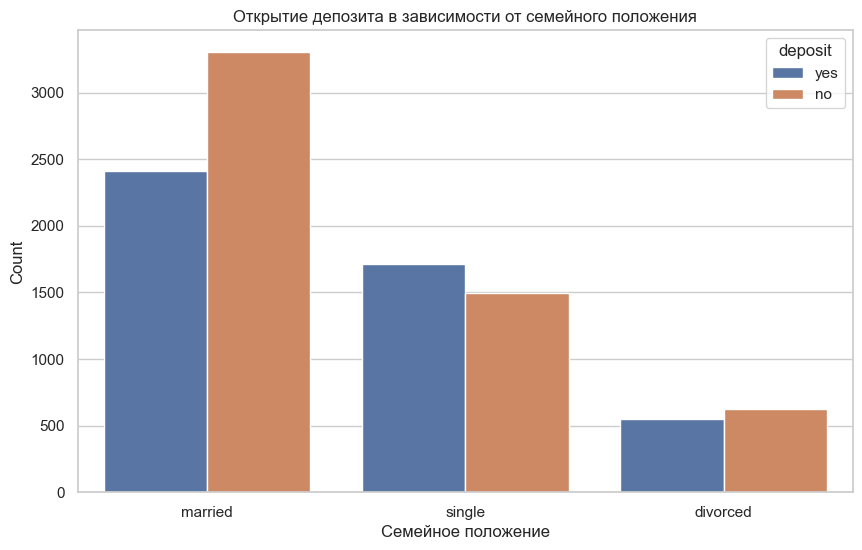

In [25]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='marital', hue='deposit', )
plt.title('Открытие депозита в зависимости от семейного положения')
plt.xlabel('Семейное положение')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

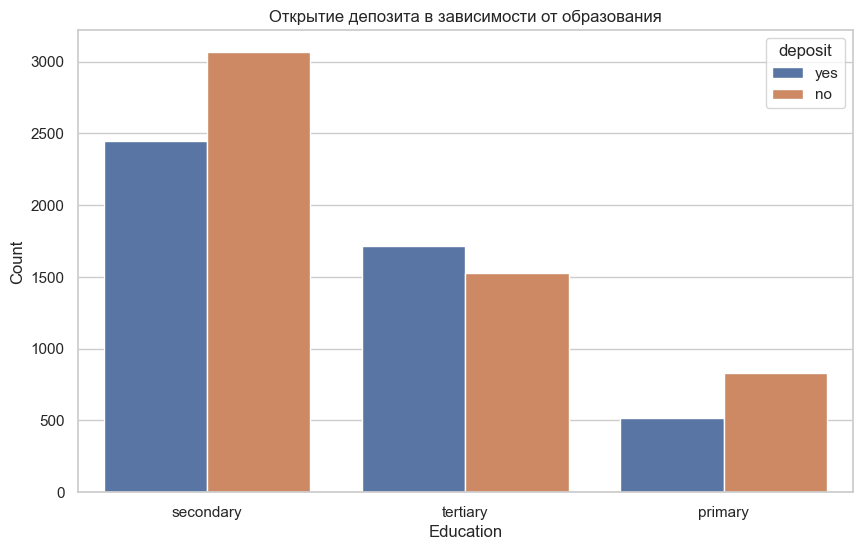

In [26]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='education_new', hue='deposit')
plt.title('Открытие депозита в зависимости от образования')
plt.xlabel('Education')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

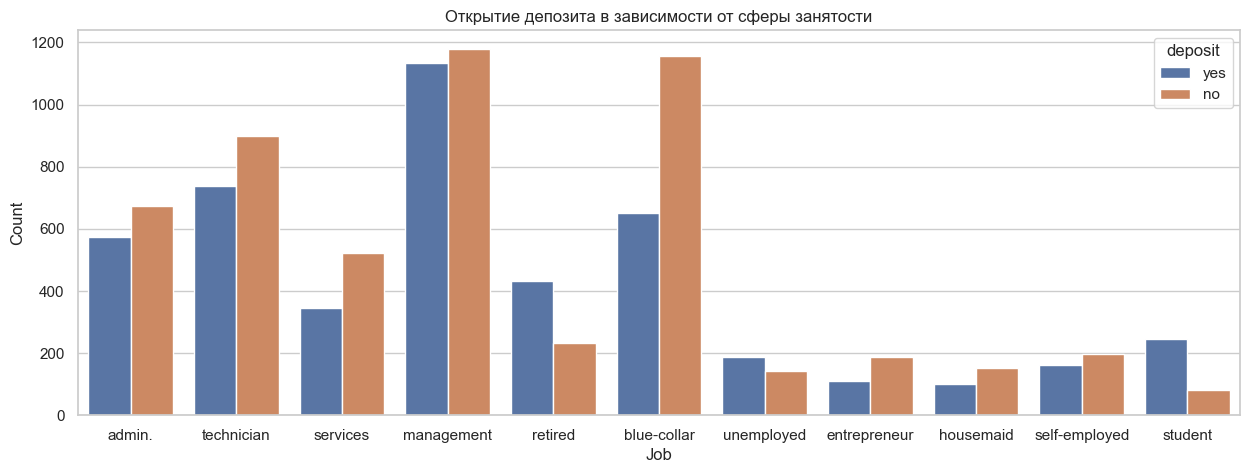

In [27]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
plt.figure(figsize=(15,5))
sns.countplot(data=df, x='job_new', hue='deposit')
plt.title('Открытие депозита в зависимости от сферы занятости')
plt.xlabel('Job')
plt.ylabel('Count')

In [28]:
df['job_new'] = df['job_new'].replace('admin.', 'admin')
df['job_new'].unique()

array(['admin', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'self-employed', 'student'], dtype=object)

### Задание 11

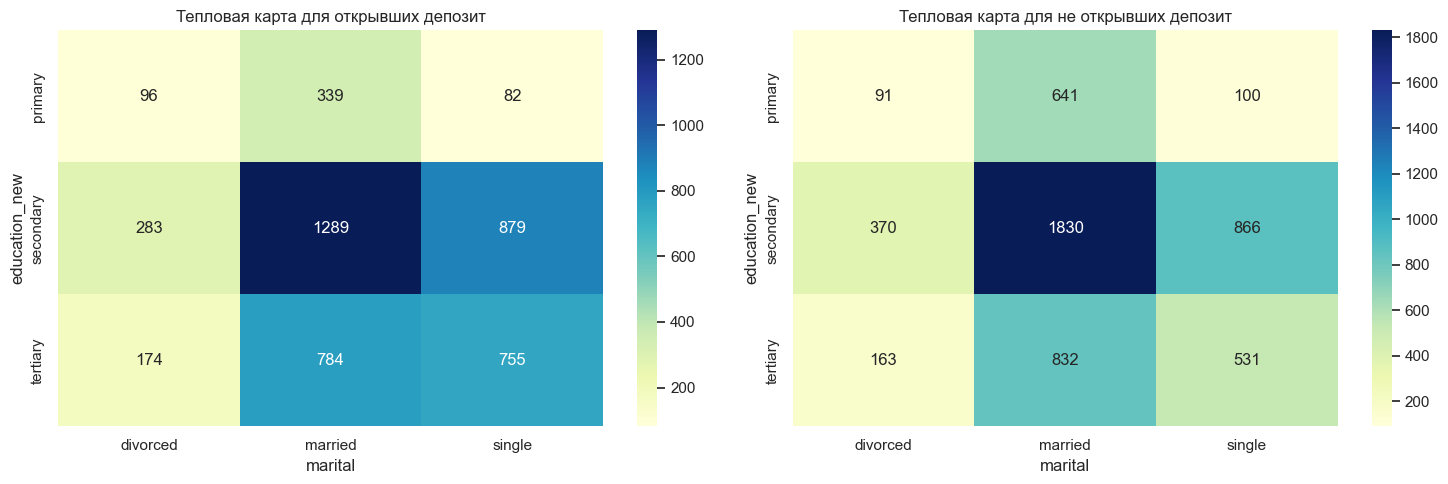

In [29]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
deposit_true = df.loc[df['deposit']=='yes']
deposit_false = df.loc[df['deposit']=='no']

# создаем сводные таблицы для уровня образования и семейного положения для обеих групп
pivot_true = pd.pivot_table(data=deposit_true, index='education_new', columns='marital', aggfunc='size', fill_value=0)
pivot_false = pd.pivot_table(data=deposit_false, index='education_new', columns='marital', aggfunc='size', fill_value=0)

# создаем тепловые карты используя сводные таблицы
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.heatmap(pivot_true, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Тепловая карта для открывших депозит')

plt.subplot(1, 2, 2)
sns.heatmap(pivot_false, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Тепловая карта для не открывших депозит')

plt.tight_layout()
plt.show()

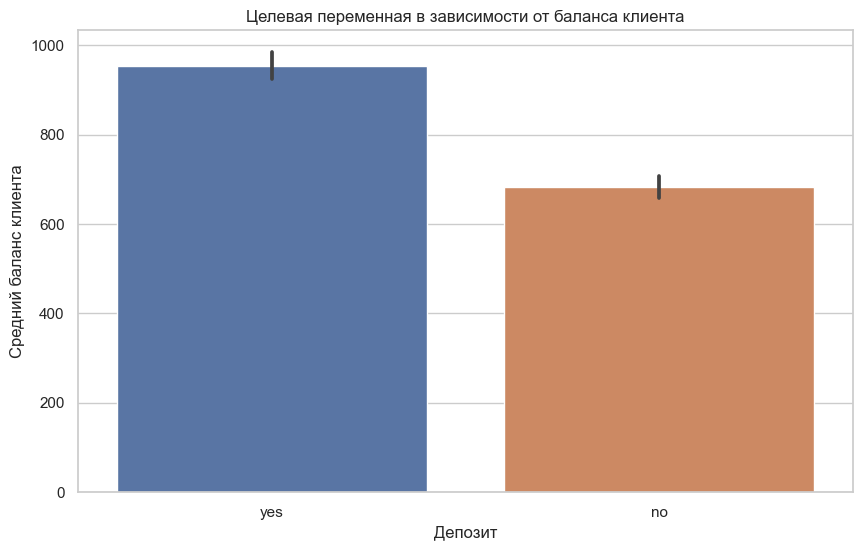

In [30]:
pd.pivot_table(data=df, index='deposit', values='balance_new', aggfunc='mean')

plt.figure(figsize=(10,6))
sns.barplot(data=df, x='deposit', y='balance_new')
plt.title('Целевая переменная в зависимости от баланса клиента')
plt.xlabel('Депозит')
plt.ylabel('Средний баланс клиента')
plt.show()

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   age            10105 non-null  int64   
 1   marital        10105 non-null  object  
 2   default        10105 non-null  object  
 3   housing        10105 non-null  object  
 4   loan           10105 non-null  object  
 5   contact        10105 non-null  object  
 6   day            10105 non-null  int64   
 7   month          10105 non-null  object  
 8   duration       10105 non-null  int64   
 9   campaign       10105 non-null  int64   
 10  pdays          10105 non-null  int64   
 11  previous       10105 non-null  int64   
 12  poutcome       10105 non-null  object  
 13  deposit        10105 non-null  object  
 14  balance_new    10105 non-null  float64 
 15  job_new        10105 non-null  object  
 16  education_new  10105 non-null  object  
 17  age_cat        10105 non-null  

## Часть 3: преобразование данных

### Задание 1

In [32]:
# преобразуйте уровни образования
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(df['education_new'])
df['education_le'] = encoder.transform(df['education_new'])

print(df['education_le'].sum())
print(df['education_le'].unique())

11995
[1 2 0]


In [33]:
df['age_le'] = encoder.fit_transform(df['age_cat'])
df['age_le'].unique()

array([2, 1, 0, 4, 3])

### Задания 2 и 3

In [34]:
# преобразуйте бинарные переменные в представление из нулей и единиц
lb = preprocessing.LabelBinarizer()
lb.fit(df['deposit'])
df['deposit'] = lb.transform(df['deposit'])
print(round(df['deposit'].std(),3))


0.499


In [35]:
features = ['default', 'housing', 'loan']
ans = 0

for feature in features:
    lb.fit(df[feature])
    df[feature] = lb.transform(df[feature])
    ans += df[feature].mean()

print(round(ans,3))

0.635


### Задание 4

In [36]:
# создайте дамми-переменные
features = ['job_new','marital','contact','month','poutcome']
for feature in features:
    dummies = pd.get_dummies(df[feature], prefix=feature)
    df = pd.concat([df, dummies], axis=1)
    
df.columns


Index(['age', 'marital', 'default', 'housing', 'loan', 'contact', 'day',
       'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'deposit', 'balance_new', 'job_new', 'education_new', 'age_cat',
       'education_le', 'age_le', 'job_new_admin', 'job_new_blue-collar',
       'job_new_entrepreneur', 'job_new_housemaid', 'job_new_management',
       'job_new_retired', 'job_new_self-employed', 'job_new_services',
       'job_new_student', 'job_new_technician', 'job_new_unemployed',
       'marital_divorced', 'marital_married', 'marital_single',
       'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

### Задания 5 и 6

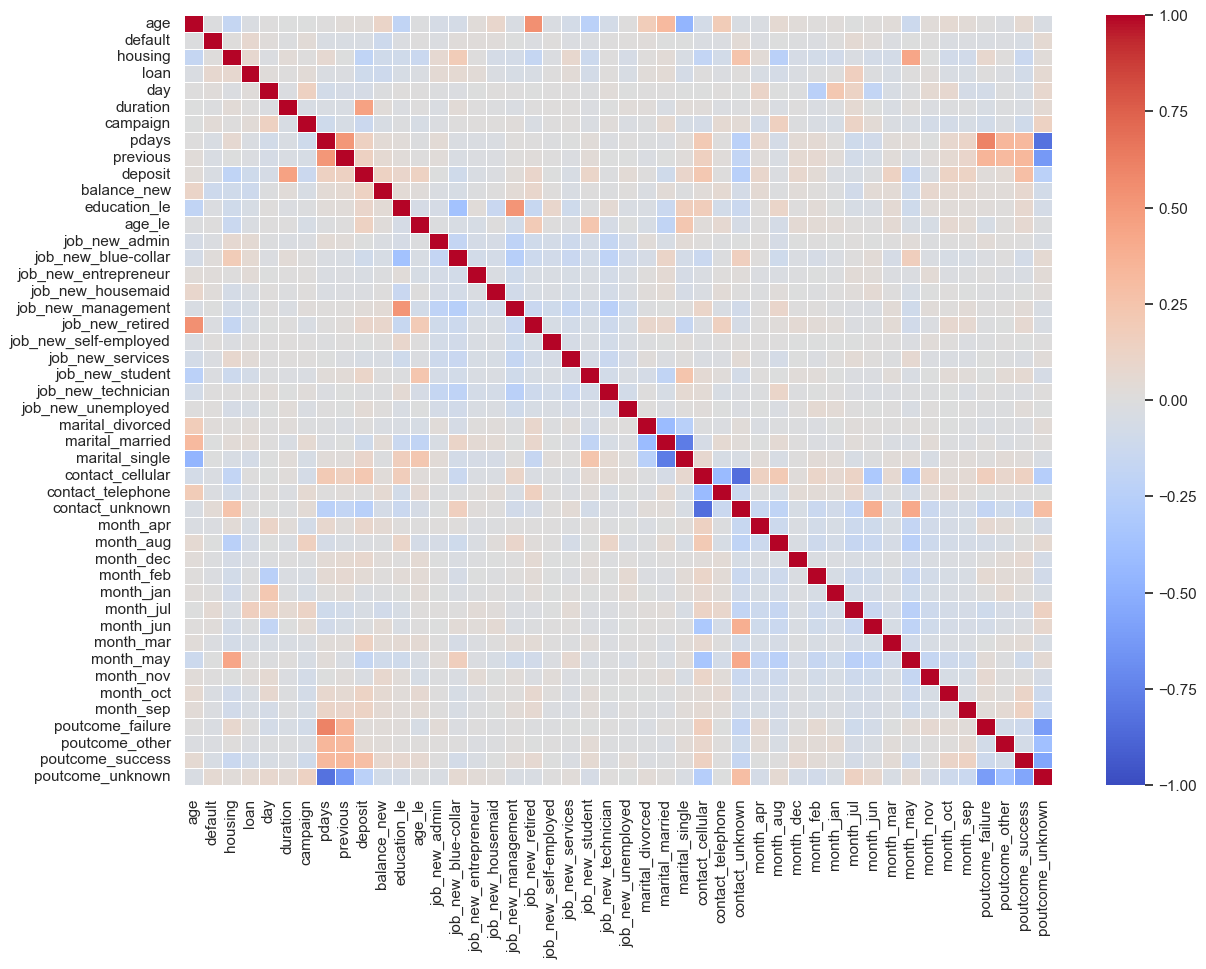

In [37]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.rcParams['figure.figsize'] = (14,10)
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 14}, vmin=-1, vmax=1)
plt.show()

In [ ]:
# можно удалить
new_corr = df.corr()['deposit'].reset_index()
sort_corr = new_corr.sort_values('deposit', ascending=False)
sort_corr.head()

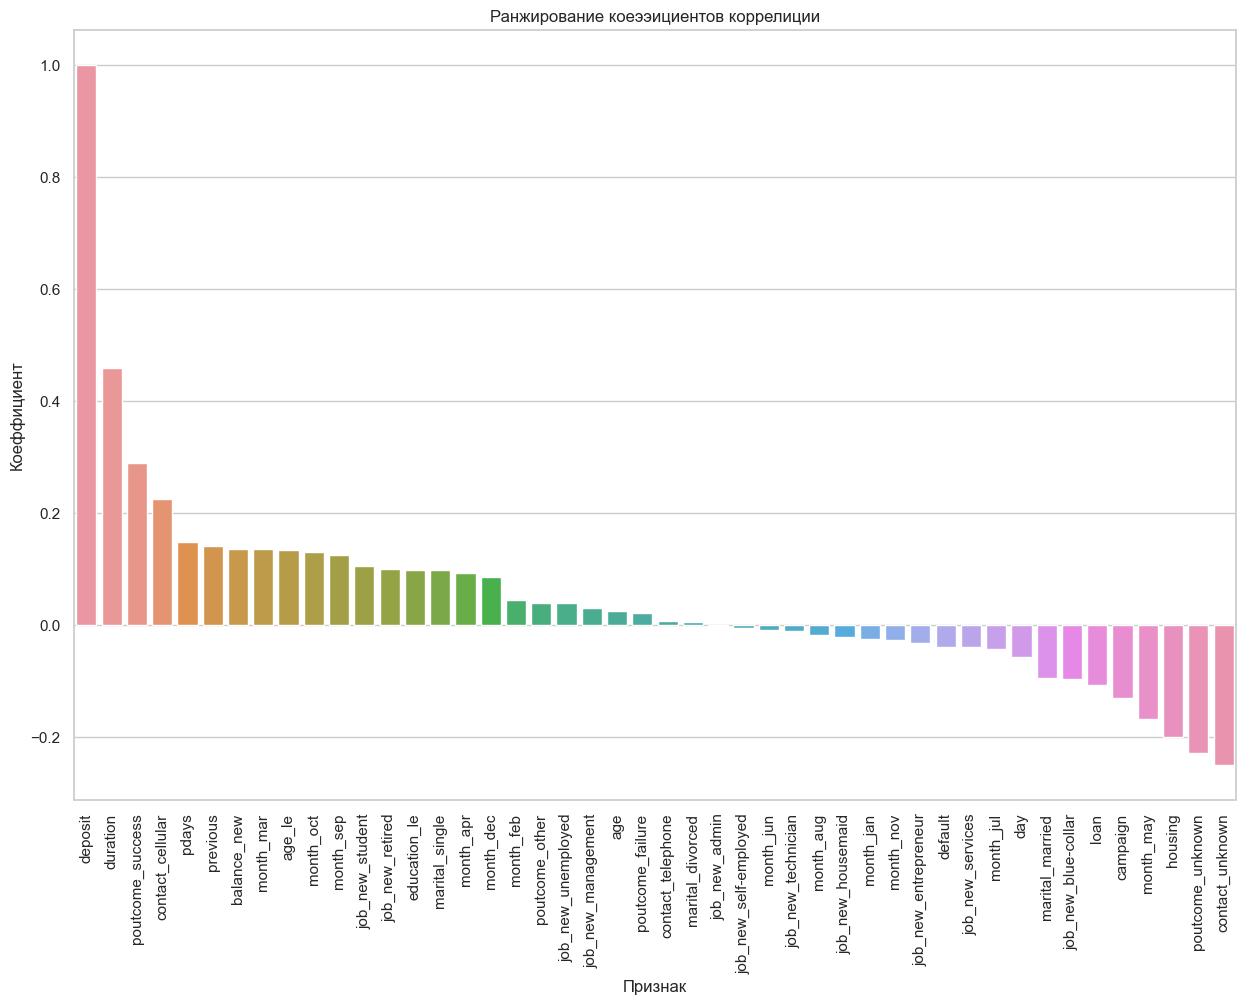

In [38]:
corr_matrix = df.corr()

corr_target = corr_matrix['deposit'].sort_values(ascending=False)
# plotting the figure
plt.figure(figsize=(15,10))
sns.barplot(x=corr_target.index, y=corr_target.values)
plt.title('Ранжирование коеээициентов коррелиции')
plt.ylabel('Коеффициент')
plt.xlabel('Признак')
plt.xticks(rotation=90)
plt.show()

### Задания 7 и 8

In [39]:
cals_to_drop = ['job_new', 'marital', 'default','loan','contact','education_new','month','poutcome','age_cat']
df.drop(cals_to_drop, axis=1, inplace=True)

In [40]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
X_test.shape

(3335, 43)

In [41]:
# рассчитайте необходимые показатели
print(round(y_test.mean(),2))

0.46


### Задание 9

In [42]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
selected_features = selector.get_support(indices=True)
features_names = X.columns[selected_features]
print(features_names)

Index(['housing', 'duration', 'campaign', 'pdays', 'previous', 'balance_new',
       'age_le', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


In [43]:
X = df[features_names]
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)


### Задание 10

In [44]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mean_first_predictor = X_test_scaled[:,0].mean()
print(round(mean_first_predictor,2))

0.48


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [45]:
# обучите логистическую регрессию и рассчитайте метрики качества
lr_model = linear_model.LogisticRegression(
    solver='sag',
    max_iter=1000,
    random_state=42
)

lr_model.fit(X_train_scaled,y_train)
prediction = lr_model.predict(X_test_scaled)

print(f' Accuracy for linear regression model: {round(metrics.accuracy_score(prediction,y_test),2)}')

 Accuracy for linear regression model: 0.81


### Задания 2,3,4

In [46]:
# обучите решающие деревья, настройте максимальную глубину
dt_model = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

dt_model.fit(X_train_scaled, y_train)
y_pred = dt_model.predict(X_test_scaled)
y_train_pred = dt_model.predict(X_train_scaled)

print(f' Accuracy for linear regression model: {round(metrics.accuracy_score(y_train_pred,y_train),2)}')
print(f' Accuracy for linear regression model: {round(metrics.accuracy_score(y_pred,y_test),2)}')

 Accuracy for linear regression model: 1.0
 Accuracy for linear regression model: 0.75


### Задание 5

In [47]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
param_grid = {'min_samples_split':[2,5,7,10], 'max_depth':[3,5,7]}

gs_model = GridSearchCV(dt_model, param_grid=param_grid)
gs_model.fit(X_train_scaled, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 7, 10]})

In [48]:
best_model = gs_model.best_estimator_
best_params = gs_model.best_params_

best_model.fit(X_train_scaled, y_train)
y_pred_gs = best_model.predict(X_test_scaled)
print(f'F1 metric for gs_model: {round(metrics.f1_score(y_pred_gs, y_test),2)}')

F1 metric for gs_model: 0.81


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [50]:
# обучите на ваших данных случайный лес
rf_model = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train_scaled,y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
print(f'Accuracy of Random Forrest model for Test data: {round(metrics.accuracy_score(y_pred_rf, y_test),2)}')
print(f'Recall metric of Random Forrest model for Test data: {round(metrics.recall_score(y_pred_rf, y_test),2)}')

Accuracy of Random Forrest model for Test data: 0.83
Recall metric of Random Forrest model for Test data: 0.8


### Задания 2 и 3

In [51]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb_model = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)
print(f'F1 metric for gs_model: {round(metrics.f1_score(y_pred_gb, y_test),2)}')

F1 metric for gs_model: 0.82


### Задание 4

In [61]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [('gb',gb_model), ('dt', best_model),('lr', lr_model)]

stack_model = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=lr_model    
)

stack_model.fit(X_train_scaled, y_train)
y_pred_stack = stack_model.predict(X_test_scaled)
print(f'Precision metric for stacking: {round(metrics.f1_score(y_test, y_pred_stack),2)}')

Precision metric for stacking: 0.81


### Задание 5

In [58]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
feature_indicies = np.argsort(gb_model.feature_importances_)[::-1][:3]
feature_names = X.columns[feature_indicies]
print(f'Top 3 features:')
for feature in feature_names:
    print(feature)

Top 3 features:
duration
poutcome_success
contact_unknown


### Задания 6,7,8

In [65]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
import logging
from optuna import trial

# turning off all the logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    # Определите пространство поиска для гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    #creating rf model
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
   
   #fitting model and predicting 
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    f1 = metrics.f1_score(y_test, y_pred)
    
    return f1

# Creating study with direction='maximize' to get the maximum f1-score
study = optuna.create_study(direction='maximize')  

# starting the optimazation
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_f1 = study.best_value
print('Best hyperparams: ', best_params)
print('Best f1-score: ', round(best_f1,2))

Best hyperparams:  {'n_estimators': 198, 'max_depth': 25, 'min_samples_leaf': 3}
Best f1-score:  0.8249370277078086


In [67]:
best_rf = ensemble.RandomForestClassifier(
    n_estimators = study.best_params['n_estimators'],
    max_depth = study.best_params['max_depth'],
    min_samples_leaf = study.best_params['min_samples_leaf'],
    random_state=42
)
best_rf.fit(X_train_scaled, y_train)
y_pred = best_rf.predict(X_test_scaled)
print(f'Accuracy for best params: {round(metrics.accuracy_score(y_test, y_pred),2)}')

Accuracy for best params: 0.83
